In [2]:
# cd drive/MyDrive/Colab\ Notebooks/cells

In [12]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import geo
import utils

# set device and load models
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gm, gm_opt, gm_loss_hist = utils.load_model("gmvae_20230221_014308.pt", "gmvae", {"input_dim": 2766, "latent_dim": 2, "num_clusters": 5}, dev)
vae, vae_opt, vae_loss_hist = utils.load_model("vae_20230221_014308.pt", "vae", {"input_dim": 2766, "latent_dim": 2}, dev)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [3]:
from geo import compute_length_of_curve, get_Riemannian_metric

# compute the length of two crossing curves in latent space
curve1 = torch.tensor([[-2, -2], [-1.5, -1.5], [-1, -1], [-0.5, -0.5], [0, 0], [0.5, 0.5], [1, 1], [1.5, 1.5], [2, 2]]).to(dev)
curve2 = torch.tensor([[-2, 2], ## compute the geodesic between two points in latent space
[-1.5, 1.5], [-1, 1], [-0.5, 0.5], [0, 0], [0.5, -0.5], [1, -1], [1.5, -1.5], [2, -2]]).to(dev)

vae_len1 = compute_length_of_curve(curve1, vae.decode, get_Riemannian_metric).item()
vae_len2 = compute_length_of_curve(curve2, vae.decode, get_Riemannian_metric).item()

gm_len1 = compute_length_of_curve(curve1, gm.decode, get_Riemannian_metric).item()
gm_len2 = compute_length_of_curve(curve2, gm.decode, get_Riemannian_metric).item()

print("  VAE: %f, %f" % (vae_len1, vae_len2))
print("GMVAE: %f, %f" % (gm_len1, gm_len2))

  VAE: 336.583252, 456.003662
GMVAE: 162.408310, 130.855530


In [4]:
# load the data
test_loader = utils.create_dataloader("celegan", 8192, shuffle=False)
test = test_loader.dataset.data.to(dev)
print("Test data shape: %s" % str(test.shape))

# compute the latent representations 
gm.eval()
vae.eval()

gm_latent = gm.reparameterize(*gm.encode(test), temperature=0.5)[0].detach().cpu().numpy()
vae_latent = vae.encode(test)[0].detach().cpu().numpy()
print("Latent representations shape: %s" % str(gm_latent.shape))

torch.Size([86024, 2766])
Test data shape: torch.Size([86024, 2766])
Latent representations shape: (86024, 2)


In [6]:
# helpers for picking interesting latent points 
def get_index(latent, threshold=500):
    return np.where(np.abs(latent[:, 1]) > threshold)[0]

def get_i_over(latent, threshold=500):
    return np.where(latent[:, 1] > threshold)[0]

def get_i_under(latent, threshold=-500):
    return np.where(latent[:, 1] < threshold)[0]

# get the latent points
gm_subset_over = gm_latent[get_i_over(gm_latent, 500)]
gm_subset_under = gm_latent[get_i_under(gm_latent, -500)]

vae_subset_over = vae_latent[get_i_over(vae_latent, 3.5)]
vae_subset_under = vae_latent[get_i_under(vae_latent, -15)]

gm_p1, gm_p2 = gm_subset_over[0], gm_subset_under[0]
vae_p1, vae_p2 = vae_subset_over[0], vae_subset_under[0]

# cast to torch and unsqueeze
gm_p1, gm_p2 = torch.tensor(gm_p1).unsqueeze(0), torch.tensor(gm_p2).unsqueeze(0)
vae_p1, vae_p2 = torch.tensor(vae_p1).unsqueeze(0), torch.tensor(vae_p2).unsqueeze(0)

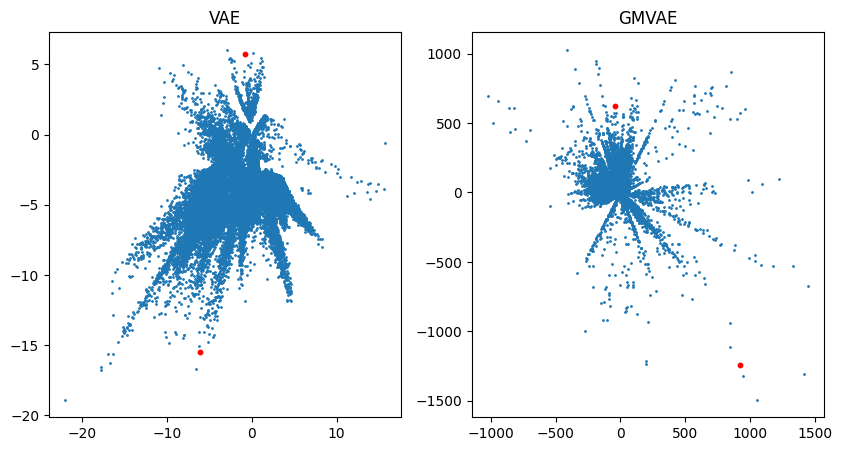

In [7]:
# plot the latent space and chosen points 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.scatter(vae_p1[0,0], vae_p1[0,1], c="red", s=10)
plt.scatter(vae_p2[0,0], vae_p2[0,1], c="red", s=10)
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.scatter(gm_p1[0,0], gm_p1[0,1], c="red", s=10)
plt.scatter(gm_p2[0,0], gm_p2[0,1], c="red", s=10)
plt.title("GMVAE")
plt.show()

Optimization terminated successfully.
         Current function value: 148.836243
         Iterations: 11
         Function evaluations: 4799
Optimization terminated successfully.
         Current function value: 6090.140625
         Iterations: 27
         Function evaluations: 12975


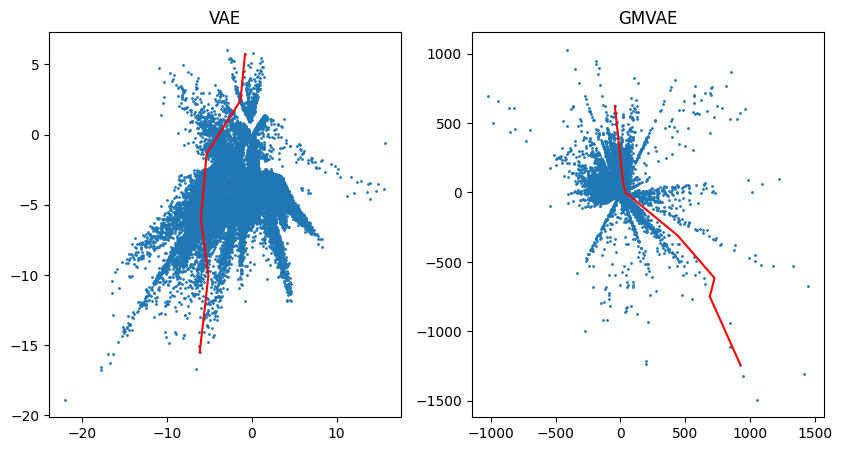

In [13]:
# ---------------------------------------------------------
# compute the geodesic between two points in latent space - 
# ---------------------------------------------------------

# lambda function which takes x and returns torch.tensor(x): 
# t = lambda x: torch.tensor(x)

# # get the latent space coordinates of the two points
# i1, i2 = 0, 1500
# p1_vae = t(vae_latent[i1:i1+1])
# p2_vae = t(vae_latent[i2:i2+1])

# p1_gm = t(gm_latent[i1:i1+1])
# p2_gm = t(gm_latent[i2:i2+1])

vae_p1, vae_p2, gm_p1, gm_p2 = vae_p1.to(dev), vae_p2.to(dev), gm_p1.to(dev), gm_p2.to(dev)

# def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100, 
# method="powell", options={"maxiter":1000, "disp":True}, loss_scale=10000, tol=1e-8, verb=False, dev=f"cuda:{0}"):

# compute the geodesic
curve_vae = geo.compute_geodesic(vae_p1, vae_p2, vae.decode, get_Riemannian_metric, 7, 
                "powell", options={"maxiter":500, "disp":True}, dev=dev).to("cpu")
curve_gm = geo.compute_geodesic(gm_p1, gm_p2, gm.decode, get_Riemannian_metric, 7, 
                "powell", options={"maxiter":500, "disp":True}, dev=dev).to("cpu")


# plot the geodesic
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.plot(curve_vae[:, 0], curve_vae[:, 1], c="r")
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.plot(curve_gm[:, 0], curve_gm[:, 1], c="r")
plt.title("GMVAE")
plt.show()

In [ ]:
len1 = geo.compute_length_of_curve(curve_gm.to(dev), gm.decode, get_Riemannian_metric)

gm_linear = geo.compute_linear(gm_p1, gm_p2, 15, dev)
len2 = geo.compute_length_of_curve(gm_linear.to(dev), gm.decode, get_Riemannian_metric)

len1, len2

(tensor(8125.5771, device='cuda:0'), tensor(11150.1855, device='cuda:0'))

### Projections


In [ ]:
asd
# do a kernel PCA on the latent space of the GMVAE
from sklearn.decomposition import KernelPCA, IncrementalPCA

# add the curve to the latent space
gm_latent2 = np.concatenate((gm_latent, curve_gm), axis=0)

# do the kernel PCA
# pca = KernelPCA(n_components=2, kernel="cosine") #kernel="rbf", gamma=0.1) # RUNS OUT OF MEMORY
pca = IncrementalPCA(n_components=2)
gm_reduced = pca.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE latent space")
plt.subplot(1, 2, 2)
plt.scatter(gm_reduced[:, 0], gm_reduced[:, 1], s=1)
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced[curve_indices, 0], gm_reduced[curve_indices, 1], c="red", s=1)
plt.title("PCA projection")
plt.show()


In [1]:
# !pip install umap-learn

In [ ]:
# Do the same with UMAP projection
import umap

# do the UMAP projection
umap_proj = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric="cosine")
gm_reduced_umap = umap_proj.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE")
plt.subplot(1, 2, 2)
# plot the projection but color the curve differently
plt.scatter(gm_reduced_umap[:, 0], gm_reduced_umap[:, 1], s=1)

# get the indices of the curve
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced_umap[curve_indices, 0], gm_reduced_umap[curve_indices, 1], c="red", s=1)
plt.title("UMAP projection")
plt.show()


### Sampling trajectories


In [64]:
# # reload the model
# gm, gm_opt, gm_loss_hist = utils.load_model("gmvae_20230221_014308.pt", "gmvae", {"input_dim": 2766, "latent_dim": 2, "num_clusters": 5}, dev)
# vae, vae_opt, vae_loss_hist = utils.load_model("vae_20230221_014308.pt", "vae", {"input_dim": 2766, "latent_dim": 2}, dev)

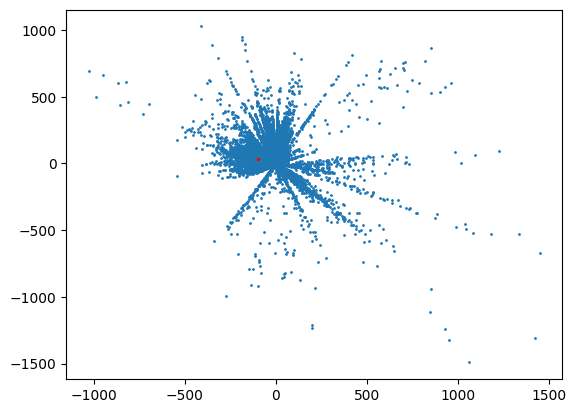

In [159]:
cell_idx = 936

# VAE 
# z0 = vae.sample(test[0], n=100, scale=2, library_size=test[0].sum())[1].detach().numpy()
# plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)

# GMVAE 
z0 = gm.sample(test[cell_idx], temperature=0.5, n=100, scale=2)[1].detach().numpy()
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)

plt.scatter(z0[:, 0], z0[:, 1], c="red", s=1)
plt.show()


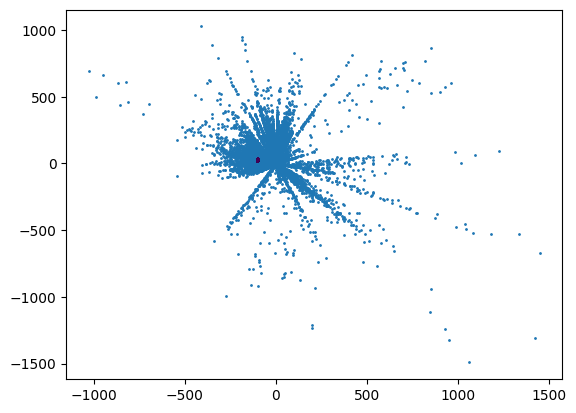

In [176]:
gene_idx = 2543 #1437

# plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1) # VAE
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1) # GMVAE
plt.scatter(z0[:, 0], z0[:, 1], c="red", s=1)

znew = torch.tensor(z0).to(dev)
steps=100
for i in range(steps):
    # znew = vae.make_step(znew, i=gene_idx, delta=0.04) # VAE
    znew = gm.make_step(znew, i=gene_idx, delta=1) # GMVAE
    znp = znew.detach().cpu().numpy()
    plt.scatter(znp[:, 0], znp[:, 1], c=[i]*znew.size(0), s=1)

plt.show()


In [177]:
test[cell_idx].argmax(), test[cell_idx].max()

(tensor(2543), tensor(116.))

In [178]:
# VAE 
# xhat_0 = vae.decode(torch.tensor(z0).to(dev), test[cell_idx].sum()).detach().numpy()
# xhat_final = vae.decode(znew).detach().cpu().numpy()

# GMVAE
xhat_0 = gm.decode(torch.tensor(z0).to(dev)).detach().numpy()
xhat_final = gm.decode(znew).detach().cpu().numpy()

np.mean(xhat_0, axis=0)[gene_idx], np.mean(xhat_final, axis=0)[gene_idx]


(41.4988, -1.6913195)

In [108]:
import pandas as pd

pd.DataFrame(xhat_0).describe().T["mean"].min()

-21.88895034790039

In [109]:
pd.DataFrame(xhat_final).describe().T["mean"].min()

-72.7220230102539